<a href="https://colab.research.google.com/github/cassandracaluag/ml-brain-tumor-detection/blob/main/ml-brain-tumor-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Enhancing Neuro-oncological Diagnosis: A Deep Learning Architecture for High-Accuracy Classification of Meningioma, Glioma, and Pituitary Brain Tumors in MRI Scans
</h1>

> EfficientNet-B2
<br>
> Cassandra Caluag, 2025 CSEF




# Load Brain Tumor Dataset into Colab Notebook

---



In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: cassandracaluag
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:00<00:00, 1.36GB/s]

In [3]:
# CORE PYTORCH & TORCHVISION
# -----------------------------------
import torch  # main pytorch library
import torch.nn as nn  # neural network layers, loss functions
import torch.optim as optim  # optimization algorithms (adam!)
from torch.utils.data import Dataset, DataLoader  # custom datasets + efficient batching/shuffling

from torchvision import transforms  # data augmentation and preprocessing
from torchvision.datasets import ImageFolder  # loads image data organized by folder structure


# MODEL ARCHITECTURE
# -----------------------------------
import timm  # access to pretrained efficientnet-b2


# EVALUATION & METRICS
# -----------------------------------
from sklearn.model_selection import train_test_split  # split dataset into train/val sets
from sklearn.metrics import confusion_matrix, f1_score  # performance metrics
import seaborn as sns  # for confusion matrix heatmaps
import matplotlib.pyplot as plt  # for plotting metrics, predictions, etc.
import matplotlib as mpl  # advanced plotting customization


# UTILITIES
#-----------------------------------
from tqdm.notebook import tqdm  # progress bars during training/testing
from PIL import Image  # image loading and manipulation
import pandas as pd  # dataframes for structured data logging
import numpy as np  # numerical operations
import os  # file path navigation & hashing
import hashlib  # for checking duplicates; data preprocessing
import random # for plotting random mri images

# Remove Duplicate Images
---


We must ensure that there are no duplicates to avoid skewing model performance/accuracy.

In [4]:
def remove_dupes(image_folder):
    hashes = {}
    duplicates = []
    total = 0

    # loop thru files in folder
    for root, dirs, files in os.walk(image_folder):
        for file in files:
            if file.endswith('.jpg'):
                file_path = os.path.join(root, file)

                # calculate hash for image
                hash = hashlib.md5(open(file_path, 'rb').read()).hexdigest()

                # see if hash already exists
                if hash in hashes:
                    duplicates.append(file_path)  # add to duplicates list
                else:
                    hashes[hash] = file_path

    # remove duplicates
    for duplicate in duplicates:
        os.remove(duplicate)
        print(f"Removed duplicate: {duplicate}")
        total += 1

    return total

# specify folder containing images
image_folder = '/content/brain-tumor-mri-dataset'
remove_dupes(image_folder)

Removed duplicate: /content/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0073.jpg
Removed duplicate: /content/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0010.jpg
Removed duplicate: /content/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0024.jpg
Removed duplicate: /content/brain-tumor-mri-dataset/Testing/notumor/Te-no_0062.jpg
Removed duplicate: /content/brain-tumor-mri-dataset/Testing/notumor/Te-no_0073.jpg
Removed duplicate: /content/brain-tumor-mri-dataset/Testing/notumor/Te-no_0083.jpg
Removed duplicate: /content/brain-tumor-mri-dataset/Testing/notumor/Te-no_0067.jpg
Removed duplicate: /content/brain-tumor-mri-dataset/Testing/notumor/Te-no_0031.jpg
Removed duplicate: /content/brain-tumor-mri-dataset/Testing/notumor/Te-no_0022.jpg
Removed duplicate: /content/brain-tumor-mri-dataset/Testing/notumor/Te-no_0052.jpg
Removed duplicate: /content/brain-tumor-mri-dataset/Testing/notumor/Te-no_0018.jpg
Removed duplicate: /content/brain-tumor-mri-dataset/Testing/notumor/Te-no_0011.jpg

297

# Define PyTorch Dataset (Brain Tumor Dataset Object)

---



A PyTorch Dataset allows adequate handling + transformation of the data, making it compatible with the PyTorch framework

In [5]:
class BrainTumorDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx]

# Data Preparation

---



<h2>Define Data Transformations</h2>

*   Transformations applied ensure data is in the right format
*   Can also diversify data, potentially leading to better performance

In [6]:
transform = transforms.Compose([
    transforms.Resize((260, 260)), # efficientnet-b2 img size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # standard normalization for imagenet images
])

In [7]:
ImageFolder("/content/brain-tumor-mri-dataset/Training").class_to_idx

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

Our label is a number, but we want it to be a word. Luckily, each number label correlates to a word label for easier understanding.

Label: 0


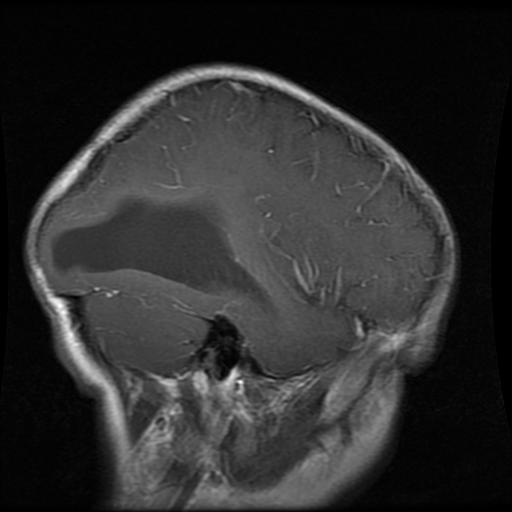

In [8]:
# before transforms! (no transforms = NT)
training_NT = BrainTumorDataset("/content/brain-tumor-mri-dataset/Training")
image, label = training_NT[888]
print("Label:", label)
image

In [9]:
full_training = BrainTumorDataset("/content/brain-tumor-mri-dataset/Training", transform=transform)
image, label = full_training[888]
print("Label:", label)
image

Label: 0


tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1008, -2.1008, -2.1008,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0182, -2.0182, -2.0182,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

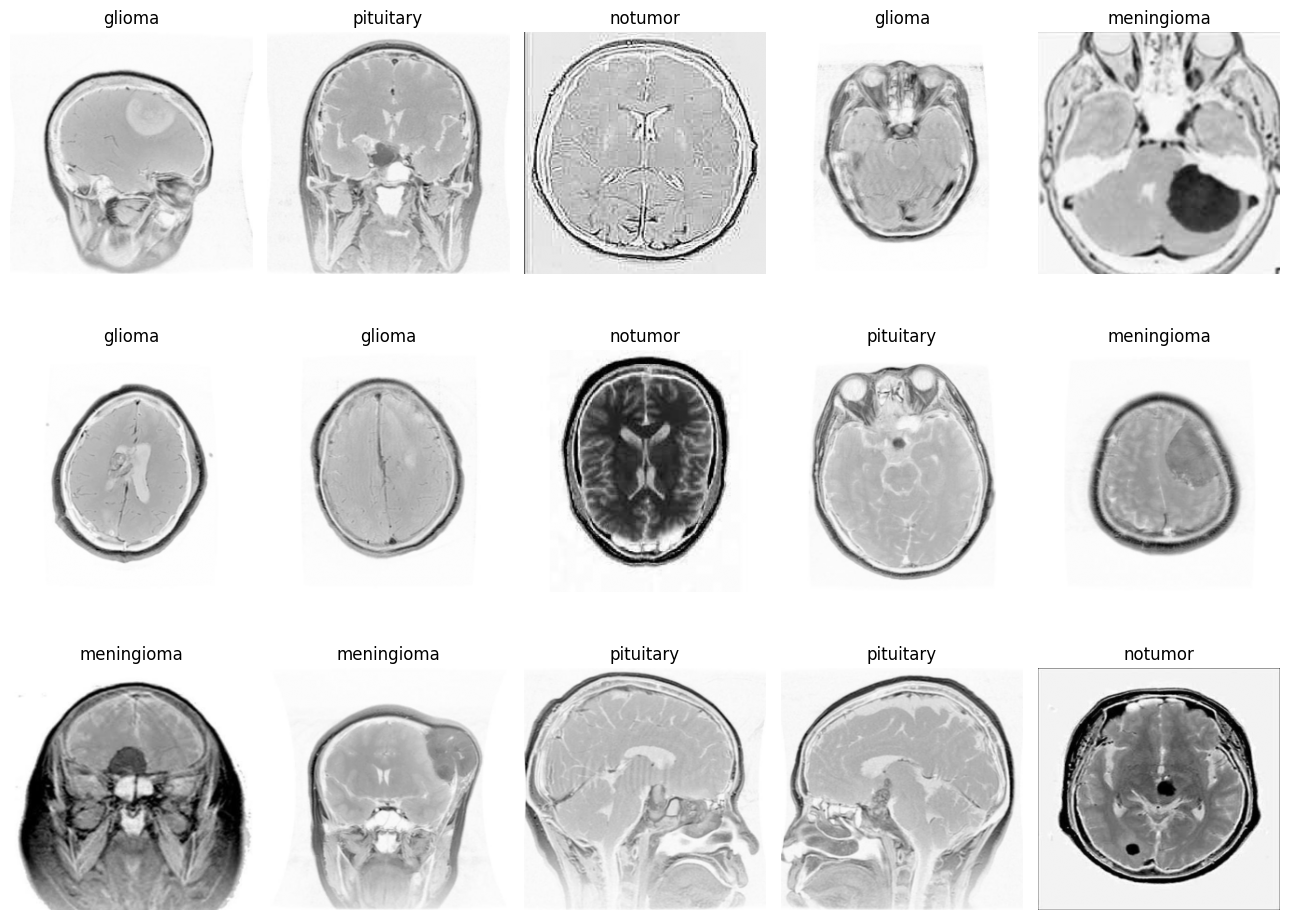

In [10]:
dataset = full_training

# create dict for idx (val) : class name (key)
class_names_dict = {v: k for k, v in ImageFolder("/content/brain-tumor-mri-dataset/Training").class_to_idx.items()}

# num of images; 5x4=20
num_images_to_display = 15

# get random indices
random_indices = random.sample(range(len(dataset)), num_images_to_display)

# create grid of subplots (for each mri scan)
fig, axes = plt.subplots(3, 5, figsize=(13, 10))

axes = axes.ravel() # flatten 2d array -> easier iteration

# process each img (based on index)
for i, idx in enumerate(random_indices):

    # get the image and label from the dataset
    image, label = dataset[idx]

    # pytorch tensors usually are [channels, width, height]
    # matplotlib expect [height, width, channels]
    # permute reorders the dimensions!
    image_np = image.permute(1, 2, 0).numpy()

    if image_np.shape[-1] == 3:
        image_np = np.dot(image_np[...,:3], [0.2989, 0.5870, 0.1140]) # weighted sum of rgb to convert to grayscale!

    axes[i].imshow(image_np, cmap="gray_r")
    axes[i].set_title(class_names_dict[label])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

<h2>Split Training Data into Training and Validation</h2>





In [11]:
train_len = len(full_training) # how many images in the training dataset
train_len

5442

In [12]:
tst = BrainTumorDataset("/content/brain-tumor-mri-dataset/Testing")
test_len = len(tst) # how many images in testing dataset
test_len

1284

In [13]:
tst = list(tst)

In [14]:
full_dataset = train_len + test_len
print("There are {} images in the Brain Tumor Dataset.".format(full_dataset))

There are 6726 images in the Brain Tumor Dataset.


There are significantly more training images than testing images. Additionally, we need a validation dataset to evaluate the model's performance after every training epoch. So, we need to split the training dataset -> training and validation data.

In [15]:
training_labels = [label for _, label in full_training] # obtain labels for each image in training dataset

In [16]:
from collections import Counter
train_key = Counter(training_labels)
num_glioma = train_key[0]
num_meningioma = train_key[1]
num_notumor = train_key[2]
num_pituitary = train_key[3]
print("Number of glioma MRI slices:", train_key[0])
print("Number of meningioma MRI slices:", train_key[1])
print("Number of MRI slices wih no tumors:", train_key[2])
print("Number of pituitary MRI slices:", train_key[3])

Number of glioma MRI slices: 1321
Number of meningioma MRI slices: 1331
Number of MRI slices wih no tumors: 1350
Number of pituitary MRI slices: 1440


In [17]:
training_labels[:5] # Data is not shuffled yet, so first five will be glioma tumors.

[0, 0, 0, 0, 0]

Since each class has around the same number of files, this indicates that the training data is relatively balanced.

In [18]:
X_train, X_val, y_train, y_val = train_test_split(full_training, training_labels, test_size=0.25, stratify=training_labels, random_state=8)

In [19]:
print(len(X_train))

4081


In [20]:
print(len(X_val))

1361


```stratify=training_labels``` ensures that the distribution of classes in new training and validations datasets is similar to the distribution in the original training dataset.
*   without stratification, the classes will not be distributed evenly, introducing bias to the model.
* stratification helps create more reliable and balanced training and datasets

```X_train``` or ```X_val``` represents the MRI scan image (the features) for training or validation

```y_train``` or ```y_val``` represents the tumor class (target variable) for training or validation




<h2> Split Training Dataset </h2>







*   training images to gauge model performance (provide quantitative performance metrics like accuracy, F1-score)
*   training images for 'real world' testing - provide visualizations using gradcam and probabilities



In [21]:
print(test_len)

1284


In [22]:
test_labels = [label for _, label in tst] # get labels for training dataset

In [23]:
test_key = Counter(test_labels)
num_glioma = test_key[0]
num_meningioma = test_key[1]
num_notumor = test_key[2]
num_pituitary = test_key[3]

print("Number of glioma MRI slices:", test_key[0])
print("Number of meningioma MRI slices:", test_key[1])
print("Number of MRI slices wih no tumors:", test_key[2])
print("Number of pituitary MRI slices:", test_key[3])

Number of glioma MRI slices: 299
Number of meningioma MRI slices: 304
Number of MRI slices wih no tumors: 381
Number of pituitary MRI slices: 300


In [24]:
full_key = train_key + test_key

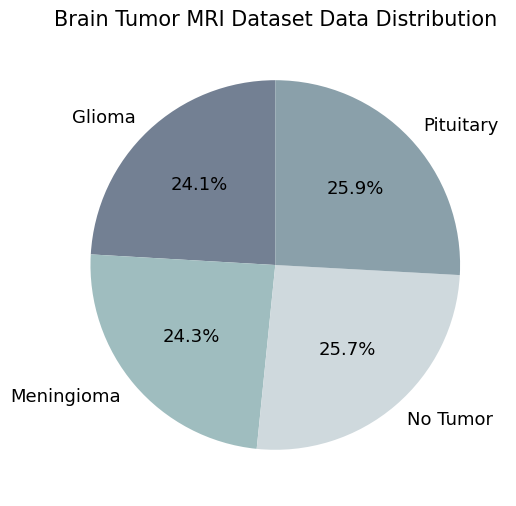

In [25]:
# data
labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
sizes = [full_key[0]/4, full_key[1]/4, full_key[2]/4, full_key[3]/4]  # percentage values
colors = ['#738093', '#9FBDBF', '#CFD9DD', '#8AA0AA']

# create pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 13})
plt.title('Brain Tumor MRI Dataset Data Distribution', fontsize=15)
plt.show()

In [26]:
X_test, X_viz, y_test, y_viz = train_test_split(tst, test_labels, test_size=0.003, stratify=test_labels)

In [27]:
print(len(X_viz))

4


In [28]:
print(len(X_test))

1280


# Create Model Architecture

---



w/ EfficientNet-B2 pre-trained model!
* EfficientNet-B2's 9.2 million parameters provided sufficient model capacity to learn complex anatomical features in brain scans without requiring the computational resources of larger architectures like EfficientNet-B4 (19M parameters) or ResNet-50 (25M parameters). This made it ideal for training on Google Colab's GPU resources while still achieving clinical-grade performance.






In [29]:
print(len(X_train))
print(len(X_val))

4081
1361


In [30]:
class BrainTumorClassifier(nn.Module):
  def __init__(self, num_classes=4):
    super(BrainTumorClassifier, self).__init__()
    self.base_model = timm.create_model("efficientnet_b2", pretrained=True)
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])
    enet_out_size = self.base_model.num_features
    print(enet_out_size)
    self.classifier = nn.Linear(enet_out_size, num_classes)

  def forward(self, x):
    x = self.features(x)
    output = self.classifier(x)
    return output

In [31]:
model = BrainTumorClassifier(num_classes=4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

1408


# Training and Validation Loop

---



First, we have to define the loss function (```criterion```) and the optimizer

```criterion```: measures how much the predictions are off from the actual true class
* Cross Entropy Loss is the best loss function for multi-classification models, since it best accurately measures the difference between the predicted class and the target class, guiding the model's learning process

```optimizer```: adjusts weights and biases to minimize loss; iteratively refines the model's performance to improve accuracy
* Adam (Adaptive Moment Estimation) allows for faster convergence (quicker model training, a stable state where the model does not learn much after stability)

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Key Hyperparameter: Learning Rate
* ```lr``` controls how much the model updates its weights after how fast the model learns for each step

step = one optimization update

In [33]:
train_loader = DataLoader(X_train, batch_size=32, shuffle=True)
val_loader = DataLoader(X_val, batch_size=32, shuffle=True)

Now, we can define the training + validation loop, and train the model!

In [34]:
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
  # set model to train
  model.train()
  running_loss = 0.0
  correct = 0
  for images, labels in tqdm(train_loader, desc="Training Loop"):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * images.size(0)
  train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(train_loss)

  # set model to evaluate - use validation data to validate training
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Validation Loop"):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * images.size(0)
  val_loss = running_loss / len(val_loader.dataset)
  val_losses.append(val_loss)

  num_epoch = epoch + 1
  print("Epoch: {} ----- Train Loss: {} ------ Validation Loss: {} ------".format(num_epoch, train_loss, val_loss))

Training Loop:   0%|          | 0/128 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 1 ----- Train Loss: 0.3419318538760692 ------ Validation Loss: 0.10361630020664511 ------


Training Loop:   0%|          | 0/128 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 2 ----- Train Loss: 0.06408527573624011 ------ Validation Loss: 0.044663684652032964 ------


Training Loop:   0%|          | 0/128 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 3 ----- Train Loss: 0.02175617878820726 ------ Validation Loss: 0.04952547348444511 ------


Training Loop:   0%|          | 0/128 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 4 ----- Train Loss: 0.0171285613931312 ------ Validation Loss: 0.04793241873457426 ------


Training Loop:   0%|          | 0/128 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 5 ----- Train Loss: 0.018174706598975656 ------ Validation Loss: 0.047565573919324984 ------


In [35]:
torch.save(model.state_dict(), 'efficientnet_b2_brain_tumor.pth')

# Evaluate and Visualize Model Performance


---



In [36]:
test_loader = DataLoader(X_test, batch_size=32, shuffle=False)

Key Hyperparameter: Batch Size

* the number of training samples the model processes before the weights are updated

In [37]:
X_test_transformed = [(transform(img), label) for img, label in X_test]

# Now create the DataLoader with the transformed images
test_loader = DataLoader(X_test_transformed, batch_size=32, shuffle=False)

In [38]:
all_accuracies = []
all_f1_scores = []

model.eval()
total = 0
correct = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
  for images, labels in tqdm(test_loader, desc=f"Testing"):
    images, labels = images.to(device), labels.to(device)

    # obtain model predictions
    outputs = model(images)

    _, predicted = torch.max(outputs, 1)

    # add predicted and true labels to respective lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

    total += labels.size(0)
    correct += (predicted == labels).sum().item()


# calculate accuracy for this run!
accuracy = correct / total

# calculate avg f1-score for this run!
f1 = f1_score(true_labels, predicted_labels, average="weighted")

print(f"Run {1} - Accuracy: {accuracy*100:.2f}% - F1-Score: {f1:.2f}")

# calculate and print the accuracy and f1-score for this run!
print(f"\nAccuracy of Model: {accuracy*100:.2f}%")
print(f"F1 Score of Model: {f1:.2f}")

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Run 1 - Accuracy: 98.28% - F1-Score: 0.98

Accuracy of Model: 98.28%
F1 Score of Model: 0.98


<h3>Confusion Matrix</h3>

* a visual depiction of model performance by depicting the image predictions compared to true labels
* shows the number of true positives (TP), false positives (FP), false negatives (FN) which can be used to calculate F1 Score

Confusion Matrix:
 [[287  11   0   0]
 [  0 298   3   2]
 [  1   3 376   0]
 [  0   2   0 297]]


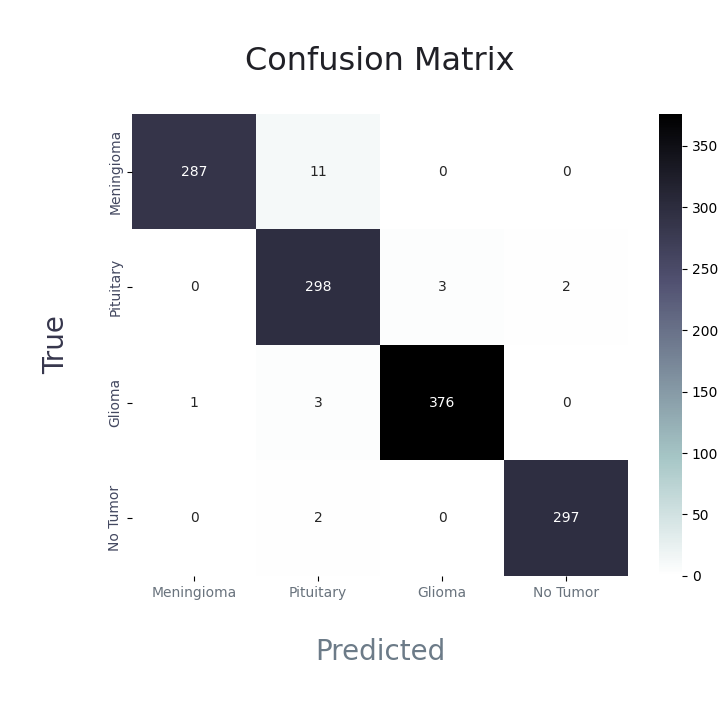

In [39]:
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cm)

# visualize confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="bone_r", xticklabels=["Meningioma", "Pituitary", "Glioma", "No Tumor"], yticklabels=["Meningioma", "Pituitary", "Glioma", "No Tumor"])
plt.title("\nConfusion Matrix\n", size=23, color="#202026")
plt.xlabel("\nPredicted\n", size=20, color="#6C7B88")
plt.ylabel("\nTrue\n", size=20, color="#36364C")
plt.xticks(fontsize=10, color="#69737D")
plt.yticks(fontsize=10, color="#434860")
plt.show()

Show F1 Score for each Class

In [40]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

class_names = ["glioma", "meningioma", "no_tumor", "pituitary"]


# display precision and recall for each class!
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F1-Score: {f1[i]}")
    print("-" * 30)

Class: glioma
  Precision: 0.9965277777777778
  Recall: 0.9630872483221476
  F1-Score: 0.9795221843003413
------------------------------
Class: meningioma
  Precision: 0.9490445859872612
  Recall: 0.9834983498349835
  F1-Score: 0.965964343598055
------------------------------
Class: no_tumor
  Precision: 0.9920844327176781
  Recall: 0.9894736842105263
  F1-Score: 0.9907773386034255
------------------------------
Class: pituitary
  Precision: 0.9933110367892977
  Recall: 0.9933110367892977
  F1-Score: 0.9933110367892977
------------------------------


<h3>Training vs. Validation Loss</h3>

* measures how well model is performing, based on training and validation data for each epoch

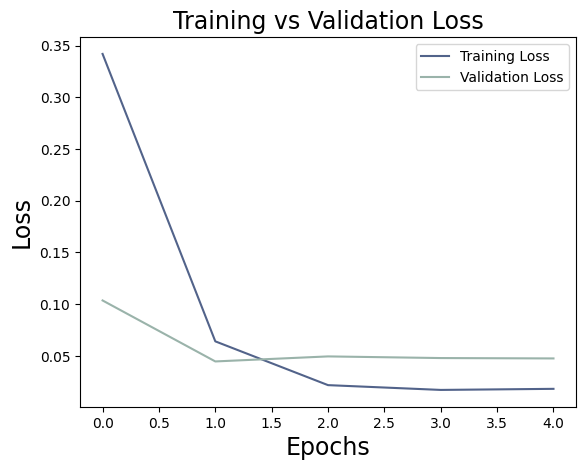

In [41]:
plt.plot(train_losses, label='Training Loss', color="#52638A")
plt.plot(val_losses, label='Validation Loss', color="#9AB3AA")
plt.xlabel('Epochs', size=17)
plt.ylabel('Loss', size=17)
plt.title('Training vs Validation Loss', size=17)
plt.legend()
plt.show()

# Test Model (with Probability Visualizations)

---



In [42]:
transform = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # standard normalization for imagenet images
])

In [43]:
class_key = {v:k for k, v in ImageFolder("/content/brain-tumor-mri-dataset/Testing").class_to_idx.items()}

In [44]:
class_key

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

In [45]:
from PIL import Image
import cv2
import numpy as np

def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')  # open the image and convert to RGB
    return image, transform(image)

# predict using model!
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# visualize - image, probabilities (w/ bar)
def visualize_predictions(original_image, label, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # display image
    axarr[0].imshow(original_image)
    axarr[0].set_title(label, fontweight='bold')
    axarr[0].axis("off")

    # display set of predictions for each class
    axarr[1].barh(class_names, probabilities, color="#516178")

    # since the image is a numpy array, use numpy syntax to determine class of highest probability
    prediction_idx = np.argmax(probabilities)
    prediction = class_key[prediction_idx]

    axarr[1].set_xlabel("Probabilities", size=17, fontweight="bold")
    axarr[1].set_title("Class Predictions", size=17, fontweight="bold")
    axarr[1].set_xlim(0, 1)

    axarr[0].set_title("Correct Class: {}".format(class_key[label].upper()), size=17, fontweight="bold")


    plt.tight_layout()
    plt.show()

Let's use X_viz (data allocated + separated from the test dataset) to visually depict the model's performance!

In [46]:
print(X_viz)

[(<PIL.Image.Image image mode=RGB size=512x512 at 0x7D2358F377D0>, 3), (<PIL.Image.Image image mode=RGB size=512x512 at 0x7D2358AAB150>, 0), (<PIL.Image.Image image mode=RGB size=512x512 at 0x7D2358F0DC10>, 1), (<PIL.Image.Image image mode=RGB size=206x244 at 0x7D2358ACE450>, 2)]


In [47]:
test_image, label = X_viz[0]
class_key[label] # actual class!

'pituitary'

In [48]:
# GRAD-CAM
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.5 MB/s e

In [49]:
# load model; instantiated from BrainTumorClassifier class
model = BrainTumorClassifier(num_classes=4)

# Load the saved state dictionary into your BrainTumorClassifier model
model.load_state_dict(torch.load('efficientnet_b2_brain_tumor.pth', map_location=torch.device('cpu')))
model.eval()

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# access last layer of model!
target_layers = [model.base_model.blocks[-1]]

# transformation defined earlier; but can put here for reference!
transform = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

1408


In [50]:
def gradcam(model, image_input, target_layers, device, transform, class_key):
  if isinstance(image_input, str):
    img = Image.open(image_input).convert('RGB')
  elif isinstance(image_input, Image.Image):
    img = image_input.convert('RGB')
  else:
    raise TypeError("image_input must be a string (file path) or a PIL Image object")

  input_tensor = transform(img).unsqueeze(0)  # add batch dimension
  input_tensor = input_tensor.to(device) # move input tensor to device

  # run gradcam by performing forward pass to get predicted class for image
  output = model(input_tensor)
  _, predicted_idx = torch.max(output, 1)
  predicted_class = predicted_idx.item()

  # define target for gradcam!
  targets = [ClassifierOutputTarget(predicted_class)]

  # initialize gradcam
  cam = GradCAM(model=model, target_layers=target_layers)

  # compute heatmap
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # [0] = single image cam

  # visualize heatmap
  img_np = np.array(img.resize((260, 260))) / 255.0
  if img_np.ndim == 2: # Convert grayscale to RGB if necessary
      img_np = np.stack([img_np]*3, axis=-1)

  # superimpose
  visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

  # display
  plt.imshow(visualization)
  plt.axis('off')
  plt.title(f"Grad-CAM: Focus for Predicted Class - {class_key[predicted_class].upper()}")
  plt.show()

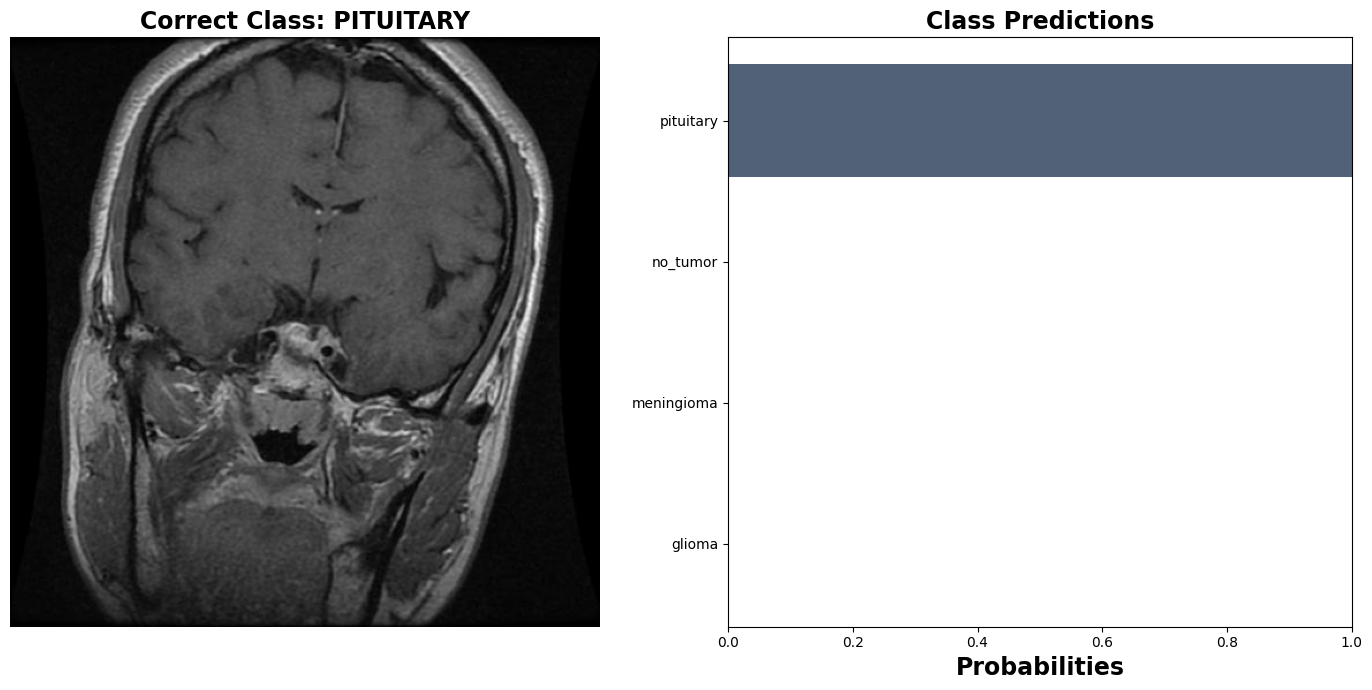

array([1.8839961e-05, 8.6579726e-05, 3.8193584e-06, 9.9989080e-01],
      dtype=float32)

In [51]:
# preprocess image!
original_image = test_image.convert('RGB') # ensure in RGB format
image_tensor = transform(original_image)  # apply transformations
image_tensor = image_tensor.unsqueeze(0) # make image tensor compatible w/ model input requirements

probabilities = predict(model, image_tensor, device)

class_names = ["glioma", "meningioma", "no_tumor", "pituitary"]
visualize_predictions(original_image, label, probabilities, class_names)

probabilities

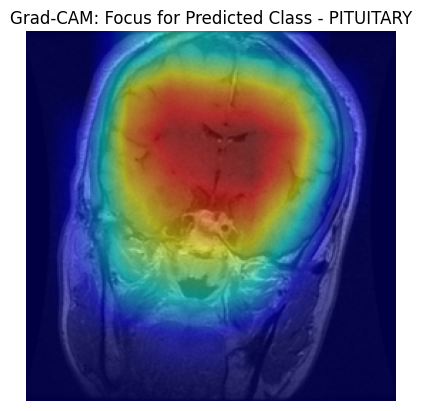

In [52]:
gradcam(model, test_image, target_layers, device, transform, class_key)

In [53]:
test_image, label = X_viz[1]
class_key[label] # actual class!

'glioma'

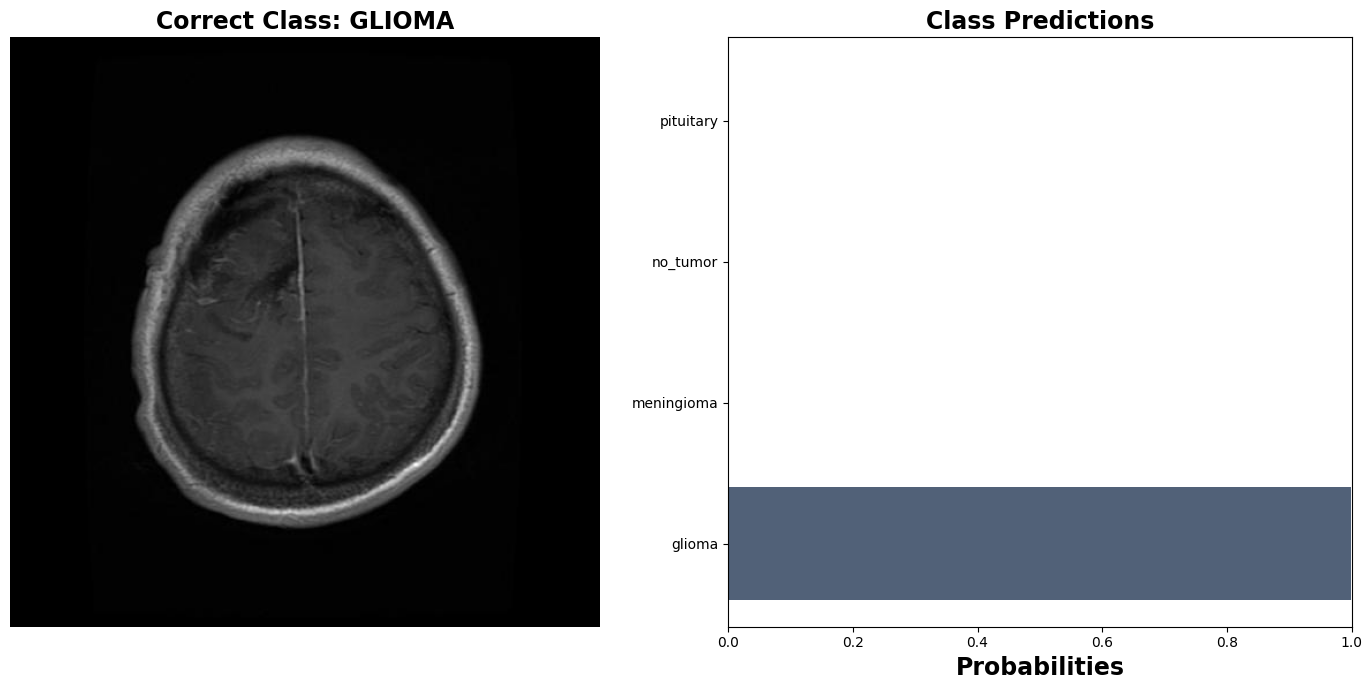

array([9.9900025e-01, 4.6288993e-04, 5.1618594e-05, 4.8534581e-04],
      dtype=float32)

In [54]:
original_image = test_image.convert('RGB')
image_tensor = transform(original_image)
image_tensor = image_tensor.unsqueeze(0)

probabilities = predict(model, image_tensor, device)

class_names = ["glioma", "meningioma", "no_tumor", "pituitary"]
visualize_predictions(original_image, label, probabilities, class_names)

probabilities

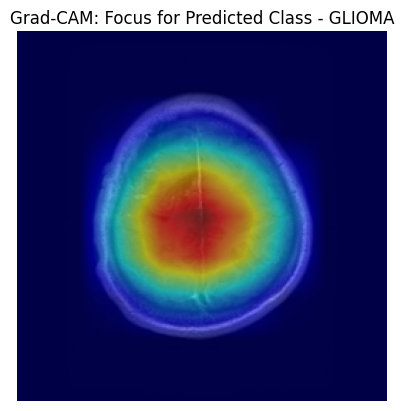

In [55]:
gradcam(model, test_image, target_layers, device, transform, class_key)

In [56]:
test_image, label = X_viz[2]
class_key[label] # actual class!

'meningioma'

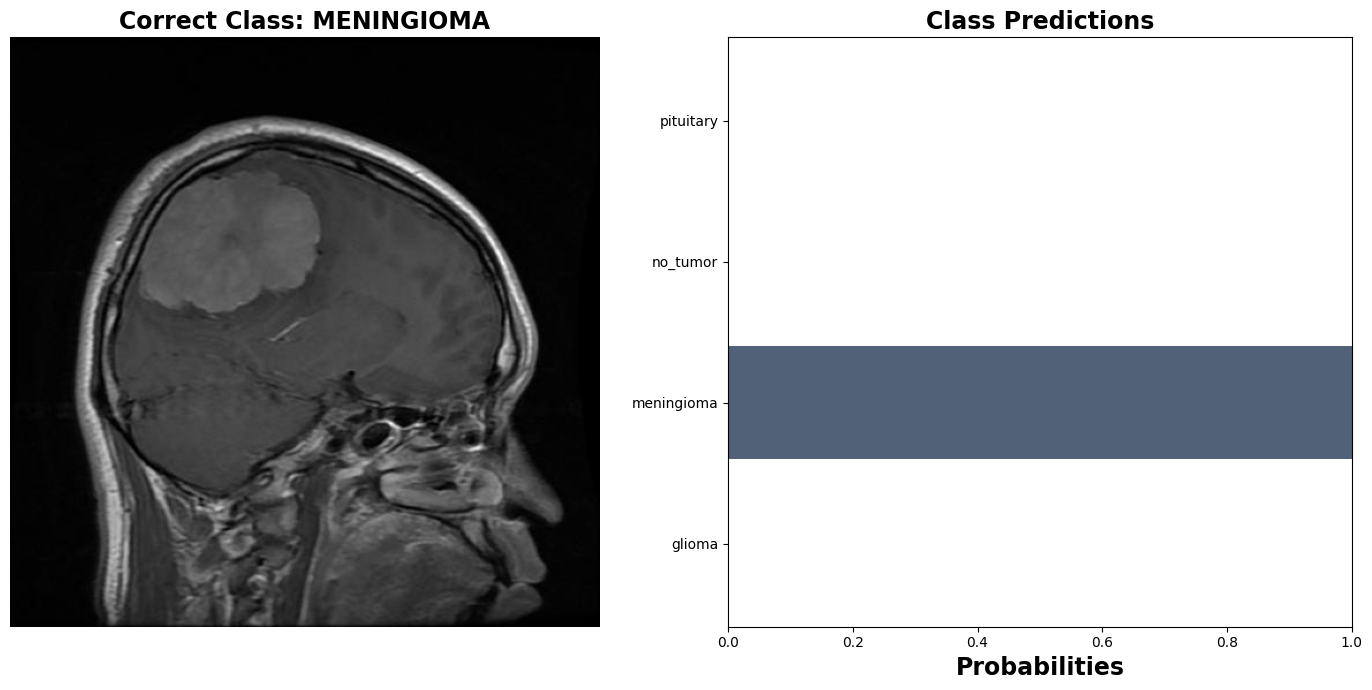

array([3.5651643e-05, 9.9981695e-01, 6.5592852e-05, 8.1858481e-05],
      dtype=float32)

In [57]:
original_image = test_image.convert('RGB')
image_tensor = transform(original_image)
image_tensor = image_tensor.unsqueeze(0)

probabilities = predict(model, image_tensor, device)

class_names = ["glioma", "meningioma", "no_tumor", "pituitary"]
visualize_predictions(original_image, label, probabilities, class_names)

probabilities

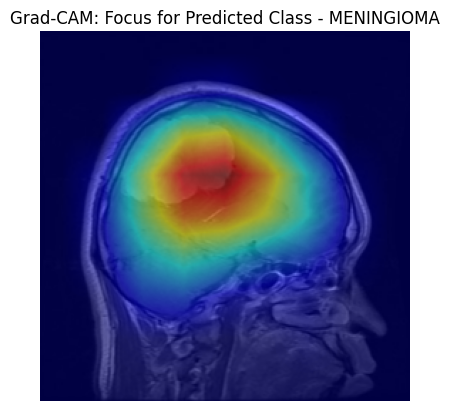

In [58]:
gradcam(model, test_image, target_layers, device, transform, class_key)

In [59]:
test_image, label = X_viz[3]
class_key[label] # actual class!

'notumor'

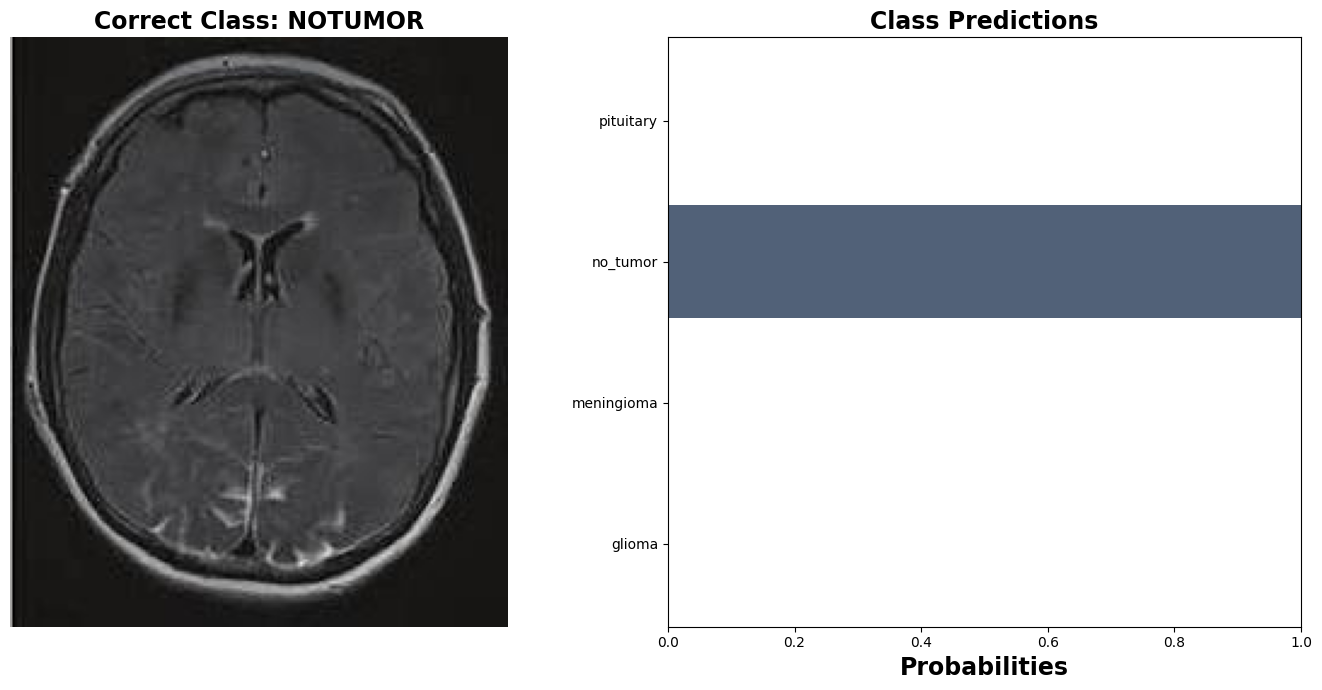

array([8.74222023e-05, 8.22328511e-05, 9.99715388e-01, 1.14888346e-04],
      dtype=float32)

In [60]:
original_image = test_image.convert('RGB')
image_tensor = transform(original_image)
image_tensor = image_tensor.unsqueeze(0)

probabilities = predict(model, image_tensor, device)

class_names = ["glioma", "meningioma", "no_tumor", "pituitary"]
visualize_predictions(original_image, label, probabilities, class_names)

probabilities

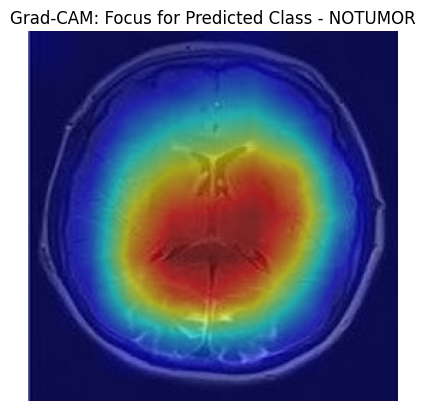

In [61]:
gradcam(model, test_image, target_layers, device, transform, class_key)